# **Denoising Autoencoder con Imágenes Médicas**

### **Héctor César Ornelas León**

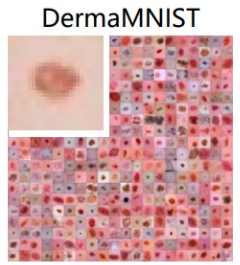

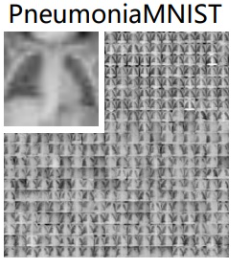

### **1. Descripción del Proyecto**

Este proyecto consiste en utilizar un denoising autoencoder con aplicación a imágenes médicas. Un autoencoder es una red neuronal que aprende a codificar y decodificar datos. El denoising autoencoder es una variante especializada que se utiliza para eliminar el ruido o distorsiones de los datos de entrada. Su objetivo es aprender una representación interna robusta y libre de ruido, lo que puede ser útil en diversas aplicaciones médicas.

### **2. Bases de Datos Utilizadas: DermaMNIST y PneumoniaMNIST**

a. **DermaMNIST**:

- Descripción: DermaMNIST es una base de datos que contiene imágenes de lesiones cutáneas. Estas imágenes son cruciales para el diagnóstico y tratamiento de enfermedades dermatológicas.
- Uso:
  - Diagnóstico Dermatológico: El denoising autoencoder puede mejorar la calidad visual de las imágenes, lo que ayuda a los dermatólogos a identificar patrones y diagnosticar enfermedades de la piel con mayor precisión.

  - Investigación Clínica: Proporciona datos visuales mejorados para estudios y análisis.

b. **PneumoniaMNIST**:

- Descripción: Similar al DermaMNIST, pero enfocado en imágenes relacionadas con la neumonía.

- Uso:

  - Detección Temprana de Neumonía: El denoising autoencoder puede mejorar la calidad de las imágenes de rayos X pulmonares, lo que ayuda en la detección temprana y el diagnóstico de neumonía.

  - Apoyo a Sistemas Automatizados: Facilita la automatización del diagnóstico asistido por computadora.

  - Investigación Médica: Proporciona imágenes más claras para análisis y estudios clínicos.

#### **3. Objetivo del Proyecto**

El objetivo principal de este proyecto es utilizar un DAE para procesar imágenes del DermaMNIST. A continuación, se describen los pasos clave:

- a. Preprocesamiento de Imágenes:
Se toman las imágenes del DermaMNIST y se introducen ruidos artificiales en ellas (por ejemplo, agregando píxeles aleatorios o aplicando filtros).
Estas imágenes ruidosas se utilizan como entrada para el DAE.

- b. Entrenamiento del Denoising Autoencoder:
El DAE se entrena utilizando un conjunto de datos compuesto por imágenes ruidosas y sus correspondientes imágenes limpias (sin ruido).
Durante el entrenamiento, el DAE aprende a mapear las imágenes ruidosas a sus versiones limpias, reduciendo así el ruido.

- c. Evaluación y Validación
Después del entrenamiento, se evalúa la capacidad del DAE para eliminar el ruido.
Se utilizan métricas como el error de reconstrucción y la calidad visual de las imágenes resultantes.

#### **4. Posibles Usos y Aplicaciones**

- Diagnóstico Médico:
Los dermatólogos pueden utilizar el DAE para mejorar la calidad de las imágenes cutáneas antes de realizar un diagnóstico.
Al reducir el ruido, se facilita la identificación de patrones relevantes en las imágenes.

- Investigación:
Los investigadores pueden estudiar enfermedades cutáneas con mayor detalle utilizando imágenes procesadas por el DAE.
Esto podría ayudar a descubrir características sutiles que no son visibles en las imágenes originales.

En resumen, este proyecto combina la potencia de deep learning con el conocimiento dermatológico para mejorar la calidad de las imágenes cutáneas y contribuir al campo de la salud y la investigación.

## Denoising autoencoder con imágenes dermatológicas

In [ ]:
#pip install medmnist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from medmnist import DermaMNIST
from medmnist import PneumoniaMNIST
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [ ]:
# Carga de imágenes
train_dataset = DermaMNIST(split="train", download=True, size=64)
val_dataset = DermaMNIST(split="val", download=True, size=64)
test_dataset = DermaMNIST(split="test", download=True, size=64)


Using downloaded and verified file: /root/.medmnist/dermamnist_64.npz
Using downloaded and verified file: /root/.medmnist/dermamnist_64.npz
Using downloaded and verified file: /root/.medmnist/dermamnist_64.npz


**Detalles del dataset DermaMNIST:**

Este dataset contiene 10,015 imágenes con diferentes lesiones de la piel categorizadas en 7 diferentes clases. Además, cuentan con 3 canales, lo que significa que para DermaMNIST se trabajará con imágenes a color. Por último, el tamaño a utilizar por imagen será de 64 x 64 pixeles.

In [ ]:
# Descripción del dataset de entrenamiento
train_dataset

Dataset DermaMNIST of size 64 (dermamnist_64)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0

In [ ]:
#Preparación de los conjuntos de imágenes
train_images = np.array([np.array(image) for image, _ in train_dataset])
val_images = np.array([np.array(image) for image, _ in val_dataset])
test_images = np.array([np.array(image) for image, _ in test_dataset])

In [ ]:
# Normalización en los valores de los pixeles de las imágenes
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [ ]:
# Función que agrega ruido a las imágenes
def add_noise(image):
    noise_factor = 0.15 # Para este caso se tomó la decisión de trabajar con un factor de ruido de 0.15
    noisy_image = image + noise_factor * np.random.normal(size=image.shape)
    return np.clip(noisy_image, 0.0, 1.0)

In [ ]:
# Preparación de los conjuntos de imágenes con ruido
train_images_noisy = np.array([add_noise(image) for image in train_images])
val_images_noisy = np.array([add_noise(image) for image in val_images])
test_images_noisy = np.array([add_noise(image) for image in test_images])

In [ ]:
# Arquitectura del Autoencoder
input_img = Input(shape=(64, 64, 3))

# Encoder

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

encoded = x


# Decoder

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
# Compilación del modelo con el optimizador Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_84 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_41 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_85 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                    

#### **Arquitectura del Autoencoder**

- Input (Entrada):
  - La entrada del autoencoder son imágenes de 64x64 píxeles con 3 canales de color (RGB).

- Encoder (Codificador):
  - Se utilizan dos capas de convolución para extraer características:
    - La primera capa convolucional tiene 16 filtros de tamaño 3x3, función de activación ReLU y relleno ‘same’.
    - Se sigue de una capa de Max Pooling con ventana 2x2 y relleno ‘same’.
    - También se aplica una capa de Dropout con una tasa del 25% para evitar el sobreajuste.
    - La segunda capa convolucional tiene 64 filtros de tamaño 3x3, función de activación ReLU y relleno ‘same’.
    - Otra capa de Max Pooling con ventana 2x2 y relleno ‘same’.
    - Nuevamente, se aplica una capa de Dropout.
    - La tercera capa convolucional tiene 128 filtros de tamaño 3x3, función de activación ReLU y relleno ‘same’.
    - Otra capa de Max Pooling con ventana 2x2 y relleno ‘same’.
    - Se aplica otra capa de Dropout.
    - La cuarta capa convolucional tiene 128 filtros de tamaño 3x3, función de activación ReLU y relleno ‘same’.
    - Otra capa de Max Pooling con ventana 2x2 y relleno ‘same’.
    - Finalmente, se aplica otra capa de Dropout.

- Encoded (Representación Oculta):
  - La salida del encoder es la representación oculta, que captura las características más relevantes de la imagen original.

- Decoder (Decodificador):

- El decodificador reconstruye la imagen a partir de la representación oculta:
    - Una capa convolucional con 32 filtros de tamaño 3x3 y función de activación ReLU, seguida de una capa de UpSampling con ventana 2x2.
    - Una capa convolucional más con 16 filtros de tamaño 3x3 y función de activación ReLU, seguida de una capa de UpSampling con ventana 2x2.
    - Otra convolucional más con 3 filtros de tamaño 3x3 y función de activación sigmoidal.


- Compilación del Modelo:
  - Se utiliza el optimizador Adam con una tasa de aprendizaje de 0.001.
  - La función de pérdida es el binary crossentropy.

**Justificación:**

- Capas Convolucionales: Las capas convolucionales son efectivas para extraer características locales y patrones en imágenes.
- Max Pooling: Ayuda a reducir la dimensionalidad y conservar las características más importantes.
- Dropout: Previene el sobreajuste al desactivar aleatoriamente algunas neuronas durante el entrenamiento.
- Función de Activación ReLU: Es comúnmente utilizada en redes neuronales debido a su eficacia en la convergencia y su capacidad para manejar gradientes.
- Función de Activación Sigmoid: Adecuada para la reconstrucción de imágenes en el rango [0, 1].

En resumen, esta arquitectura busca comprimir y luego reconstruir imágenes, capturando características relevantes y eliminando el ruido.

In [ ]:
# Entrenamiento del modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
autoencoder.fit(train_images_noisy, train_images,
                epochs=20,
                batch_size=16,
                shuffle=True,
                validation_data=(val_images_noisy, val_images),
                callbacks=[early_stopping])

Epoch 1/20
438/438 [==============================] - 7s 11ms/step - loss: 0.5945 - val_loss: 0.6010
Epoch 2/20
438/438 [==============================] - 4s 9ms/step - loss: 0.5879 - val_loss: 0.5974
Epoch 3/20
438/438 [==============================] - 4s 8ms/step - loss: 0.5876 - val_loss: 0.5930
Epoch 4/20
438/438 [==============================] - 4s 9ms/step - loss: 0.5873 - val_loss: 0.5974
Epoch 5/20
438/438 [==============================] - 4s 9ms/step - loss: 0.5872 - val_loss: 0.5926
Epoch 6/20
438/438 [==============================] - 4s 8ms/step - loss: 0.5871 - val_loss: 0.5929
Epoch 7/20
438/438 [==============================] - 4s 9ms/step - loss: 0.5870 - val_loss: 0.5925
Epoch 8/20
438/438 [==============================] - 4s 9ms/step - loss: 0.5871 - val_loss: 0.5912
Epoch 9/20
438/438 [==============================] - 4s 9ms/step - loss: 0.5869 - val_loss: 0.5908
Epoch 10/20
438/438 [==============================] - 4s 8ms/step - loss: 0.5869 - val_loss: 0.590

In [ ]:
# Evaluación del modelo
decoded_images = autoencoder.predict(test_images_noisy)

63/63 [==============================] - 1s 5ms/step


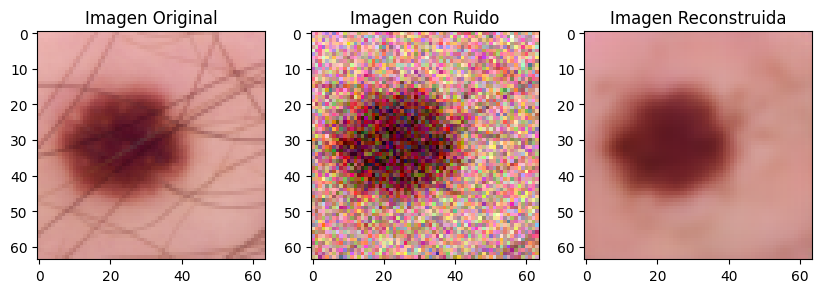

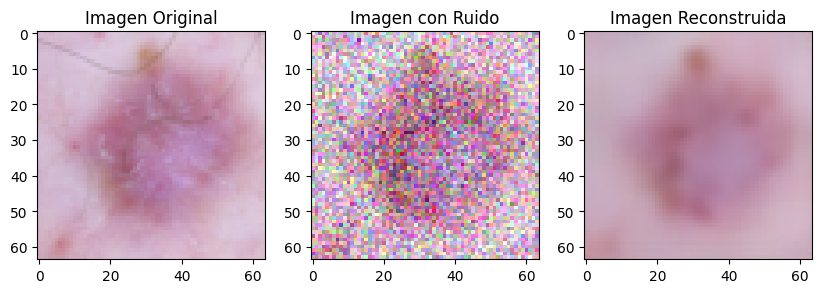

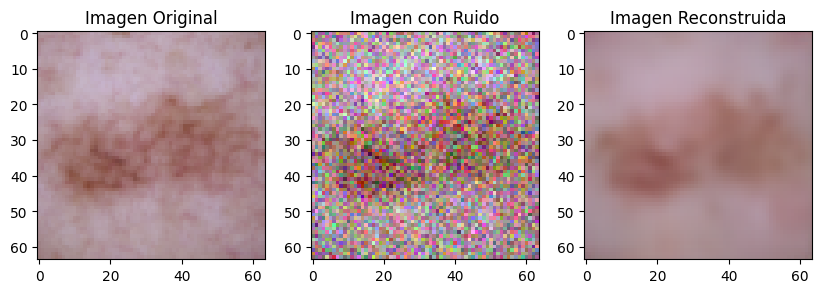

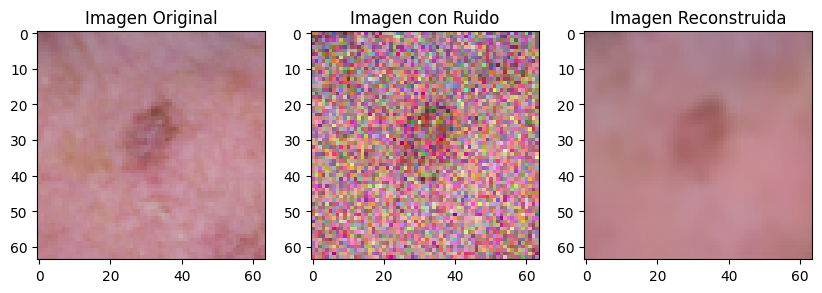

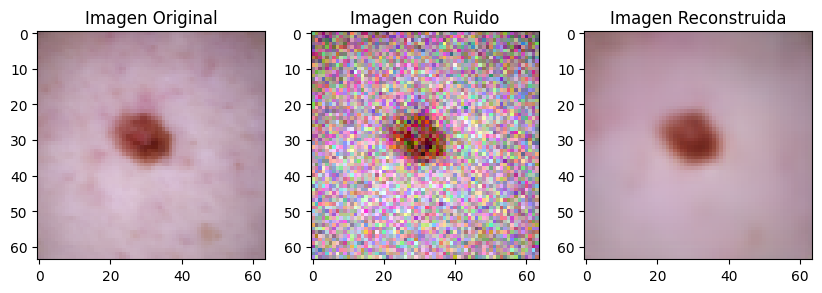

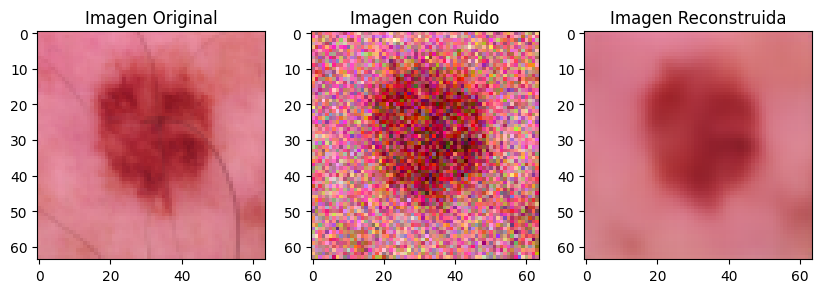

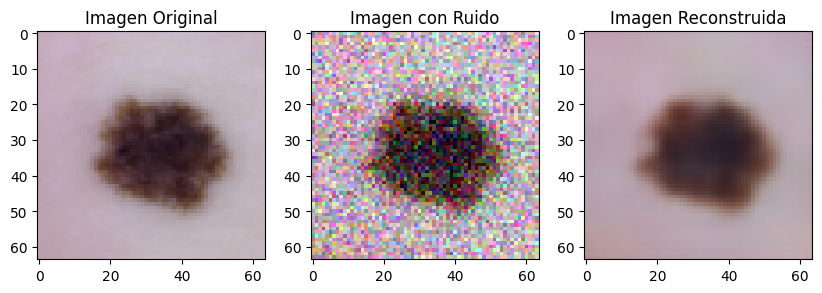

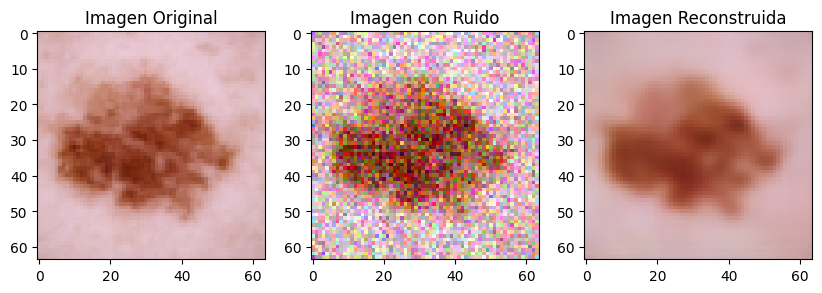

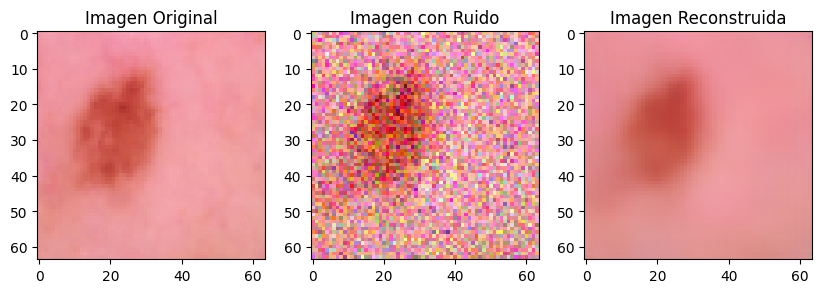

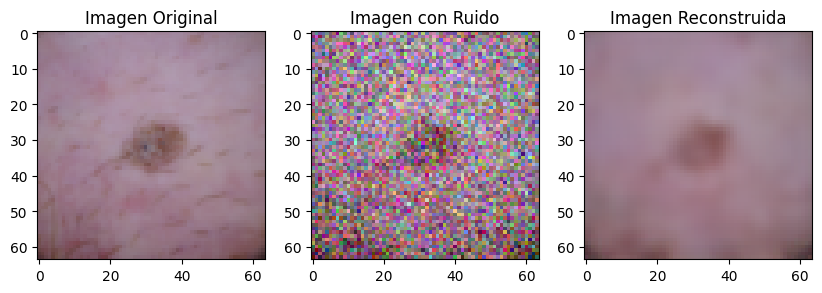

In [ ]:
# Visualización de algunas imágenes originales, con ruido y reconstruidas
num_examples = 10

for i in range(num_examples):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i].reshape(64, 64, 3))
    plt.title('Imagen Original')

    plt.subplot(1, 3, 2)
    plt.imshow(test_images_noisy[i].reshape(64, 64, 3))
    plt.title('Imagen con Ruido')

    plt.subplot(1, 3, 3)
    plt.imshow(decoded_images[i].reshape(64, 64, 3))
    plt.title('Imagen Reconstruida')

    plt.show()

En conclusión, considero que si bien hay bastante espacio para mejorar, resulta interesante como en las imágenes reconstruidas podemos quitar el ruido de las originales, por ejemplo: al estar enfocados directamente en la piel, logramos quitar el pelo que interfiere con la enfermedad cutánea y que únicamente representa ruido. De esta manera, puede mejorar significativamente el análisis de las imágenes.

## Denoising Autoencoder para imágenes de detección de neumonía

In [ ]:
# Carga de imágenes
train_dataset_1 = PneumoniaMNIST(split="train", download=True, size=224)
val_dataset_1 = PneumoniaMNIST(split="val", download=True, size=224)
test_dataset_1 = PneumoniaMNIST(split="test", download=True, size=224)

100%|██████████| 214384716/214384716 [00:43<00:00, 4883751.53it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz


In [ ]:
# Descripción del dataset de entrenamiento
train_dataset_1

Dataset PneumoniaMNIST of size 224 (pneumoniamnist_224)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

Este dataset contiene 5,856 imágenes de radiografías de tórax pediátricas. Contiene imágenes con clasificación de neumonía o normal (sin neumonía). El tamaño de las imágenes a trabajar será de 224 x 224 pixeles con un solo canal (escala de grises).

In [ ]:
# Preparación de las imágenes de PneumoniaMNIST
train_images_1 = np.array([np.array(image) for image, _ in train_dataset_1])
val_images_1 = np.array([np.array(image) for image, _ in val_dataset_1])
test_images_1 = np.array([np.array(image) for image, _ in test_dataset_1])

In [ ]:
# Normalización de los valores de los pixeles
train_images_1 = train_images_1.astype('float32') / 255.0
val_images_1 = val_images_1.astype('float32') / 255.0
test_images_1 = test_images_1.astype('float32') / 255.0

In [ ]:
# Función que agrega ruido a las imágenes
def add_noise(image):
    noise_factor = 0.2
    noisy_image = image + noise_factor * np.random.normal(size=image.shape)
    return np.clip(noisy_image, 0.0, 1.0)

In [ ]:
# Agregando el ruido a las imágenes
train_images_noisy_1 = np.array([add_noise(image) for image in train_images_1])
val_images_noisy_1 = np.array([add_noise(image) for image in val_images_1])
test_images_noisy_1 = np.array([add_noise(image) for image in test_images_1])

In [ ]:
# Arquitectura del autoencoder
input_img = Input(shape=(224, 224, 1))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)
encoded = x

# Decoder
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_1 = Model(input_img, decoded)
autoencoder_1.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_33 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                     

#### **Arquitectura del Autoencoder**

- Input (Entrada):
  - La entrada del autoencoder son imágenes de 224x224 píxeles con un canal de color (escala de grises).

- Encoder (Codificador):
  - Se utilizan dos capas de convolución para extraer características:
    - La primera capa convolucional tiene 64 filtros de tamaño 3x3, función de activación ReLU y relleno ‘same’.
    - Se sigue de una capa de Max Pooling con ventana 2x2 y relleno ‘same’.
    - También se aplica una capa de Dropout con una tasa del 20% para evitar el sobreajuste.
    - La segunda capa convolucional tiene 128 filtros de tamaño 3x3, función de activación ReLU y relleno ‘same’.
    - Otra capa de Max Pooling con ventana 2x2 y relleno ‘same’.
    - Nuevamente, se aplica una capa de Dropout.
    - La tercera capa convolucional tiene 256 filtros de tamaño 3x3, función de activación ReLU y relleno ‘same’.
    - Otra capa de Max Pooling con ventana 2x2 y relleno ‘same’.
    - Otra vez se aplica capa de Dropout.
    - La cuarta capa convolucional tiene 512 filtros de tamaño 3x3, función de activación ReLU y relleno ‘same’.
    - Otra capa de Max Pooling con ventana 2x2 y relleno ‘same’.
    - Finalmente, se aplica otra capa de Dropout.

- Encoded (Representación Oculta):
  - La salida del encoder es la representación oculta, que captura las características más relevantes de la imagen original.

- Decoder (Decodificador):

- El decodificador reconstruye la imagen a partir de la representación oculta:
    - Una capa convolucional con 512 filtros de tamaño 3x3 y función de activación ReLU, seguida de una capa de UpSampling con ventana 2x2.
    - Otra capa convolucional con 256 filtros de tamaño 3x3 y función de activación ReLU, seguida de una capa de UpSampling con ventana 2x2.
    - Una capa convolucional más con 128 filtros de tamaño 3x3 y función de activación ReLU, seguida de una capa de UpSampling con ventana 2x2.
    - Otra capa convolucional con 64 filtros de tamaño 3x3 y función de activación ReLU, seguida de otra capa de UpSampling.
    - Finalmente, una capa convolucional con 1 filtro de tamaño 3x3 y función de activación sigmoid para obtener la imagen reconstruida.

- Compilación del Modelo:
  - Se utiliza el optimizador Adam.
  - La función de pérdida es binary crossentropy.

In [ ]:
# Entrenamiento del modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
autoencoder_1.fit(train_images_noisy_1, train_images_1,
                epochs=20,
                batch_size=16,
                shuffle=True,
                validation_data=(val_images_noisy_1, val_images_1),
                callbacks=[early_stopping])

Epoch 1/20
295/295 [==============================] - 74s 205ms/step - loss: 0.6449 - val_loss: 0.6400
Epoch 2/20
295/295 [==============================] - 54s 182ms/step - loss: 0.6209 - val_loss: 0.6374
Epoch 3/20
295/295 [==============================] - 54s 182ms/step - loss: 0.6201 - val_loss: 0.6331
Epoch 4/20
295/295 [==============================] - 54s 182ms/step - loss: 0.6196 - val_loss: 0.6311
Epoch 5/20
295/295 [==============================] - 54s 182ms/step - loss: 0.6193 - val_loss: 0.6294
Epoch 6/20
295/295 [==============================] - 54s 182ms/step - loss: 0.6190 - val_loss: 0.6266
Epoch 7/20
295/295 [==============================] - 54s 182ms/step - loss: 0.6188 - val_loss: 0.6262
Epoch 8/20
295/295 [==============================] - 55s 187ms/step - loss: 0.6187 - val_loss: 0.6273
Epoch 9/20
295/295 [==============================] - 54s 182ms/step - loss: 0.6185 - val_loss: 0.6264
Epoch 10/20
295/295 [==============================] - 55s 187ms/step - l

In [ ]:
# Evaluación del modelo
decoded_images_1 = autoencoder_1.predict(test_images_noisy_1)

20/20 [==============================] - 8s 71ms/step


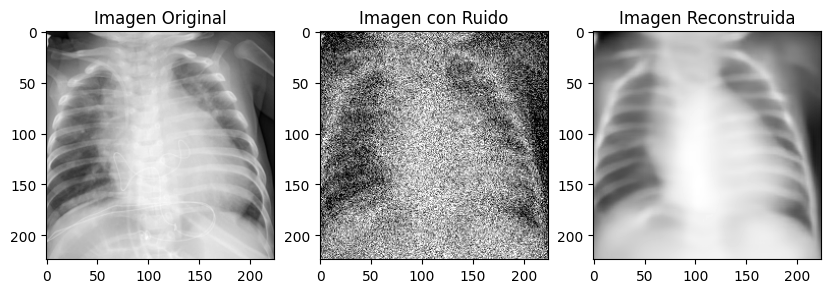

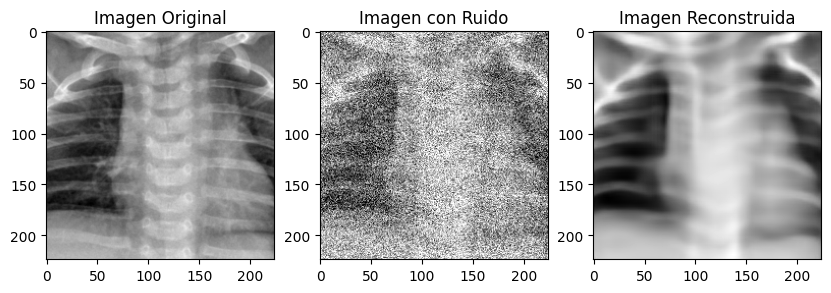

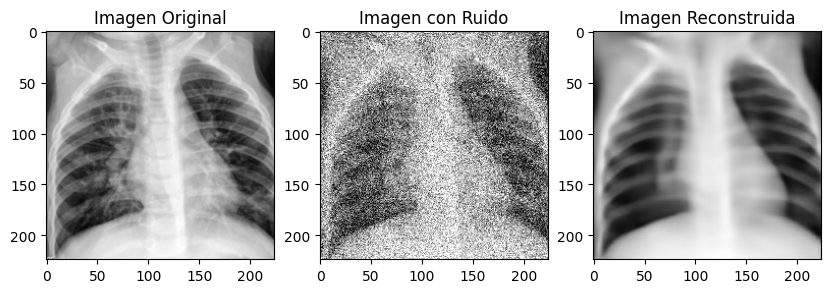

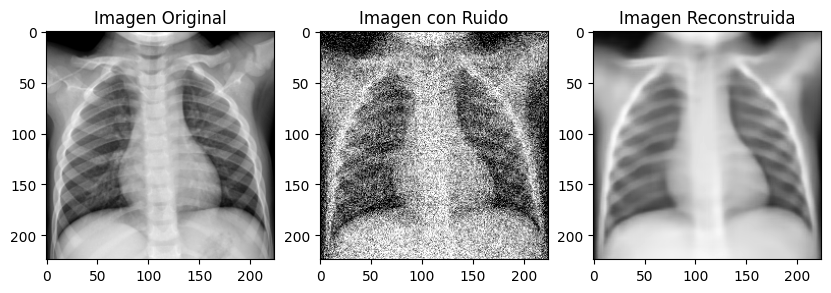

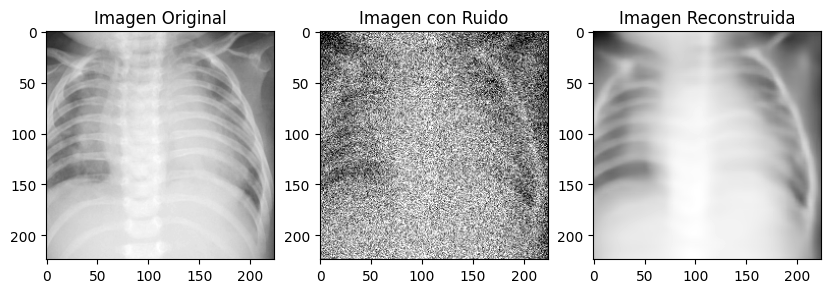

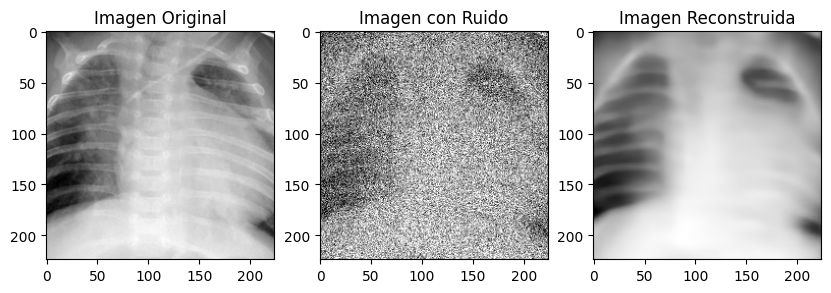

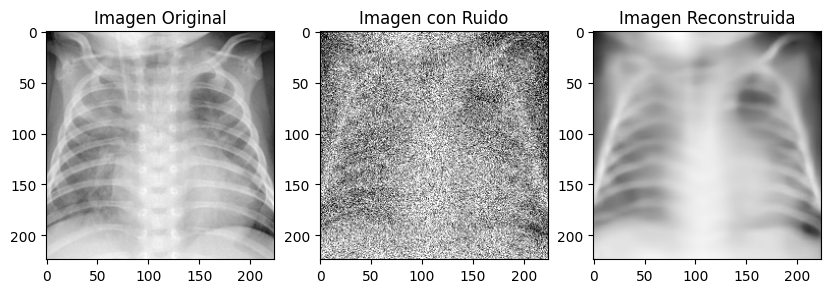

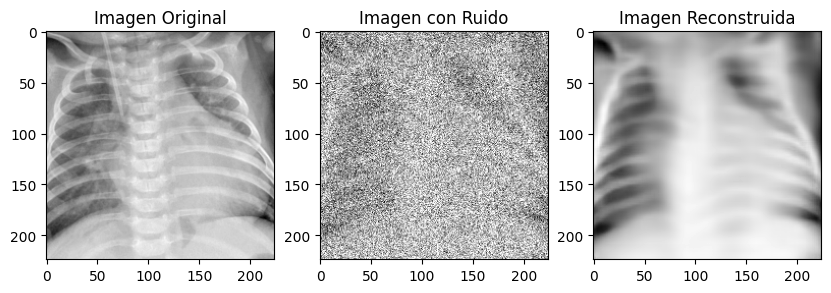

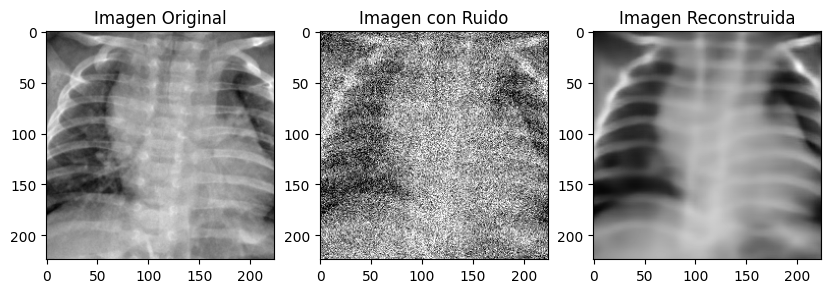

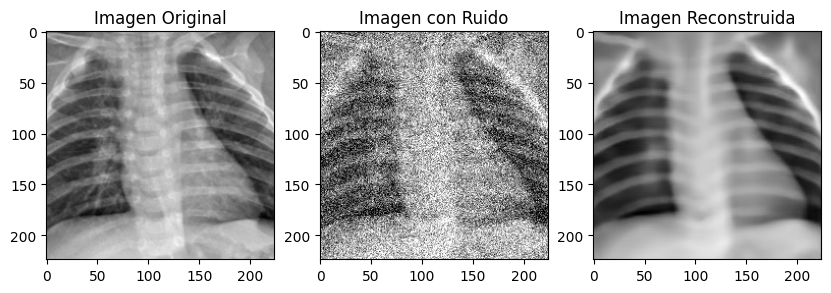

In [ ]:
# Visualización de algunas imágenes originales, ruidosas y reconstruidas
num_examples = 10

for i in range(num_examples):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(test_images_1[i].reshape(224, 224), cmap='gray')
    plt.title('Imagen Original')

    plt.subplot(1, 3, 2)
    plt.imshow(test_images_noisy_1[i].reshape(224, 224), cmap='gray')
    plt.title('Imagen con Ruido')

    plt.subplot(1, 3, 3)
    plt.imshow(decoded_images_1[i].reshape(224, 224), cmap='gray')
    plt.title('Imagen Reconstruida')

    plt.show()

En resumen, esta reconstrucción de imágenes se logró ya que se está logrando quitar el ruido de manera adecuada y no terminamos con imágenes borrosas.